# Build and evalulate our model

We'll now import the latitude, longitude and weather data we collected and saved as pickle variables with the collect_and_clean_data.ipynb notebook

## Import required packages and cleaned variables 

In [490]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import keras
from keras.layers import Input, Dense, concatenate, Conv1D, Conv2D, Flatten, BatchNormalization, Activation, GlobalMaxPool1D, MaxPooling2D, Dropout, GlobalMaxPool2D
from keras import regularizers
from keras.models import Model
import pickle
import inspect
import re
np.random.seed(123) #Control randomization 

## Import the elevation and weather data as a pickle file
Note: I imported the value as a pickle since it was easier to grab the nested arrays in cells out of that that than the csv which import as strings

In [491]:
with open('california_vineyards_elevation_weather.pkl', 'rb') as f: 
    elevation_weather_df = pickle.load(f)
    
#convert rows from a given column into a numpy array
def rows_to_2D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = ([row])
        else:
            arr = np.vstack([arr,row])
    return arr
    
#convert rows from a given column into a numpy array
def rows_to_3D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = np.array([row[0]])
        else:
            arr = np.concatenate([arr, np.array([row[0]])], axis=0)
    return arr

is_vineyard = np.array(elevation_weather_df['IsVineyard']).astype(float)
map_coords = rows_to_2D_array(elevation_weather_df['MapCoords'])
elevation = rows_to_3D_array(elevation_weather_df['ElevationMatrix'])
wind_dir = rows_to_2D_array(elevation_weather_df['WindDir'])
wind_spd = rows_to_2D_array(elevation_weather_df['WindSpd'])
precip = rows_to_2D_array(elevation_weather_df['Precip'])
temp = rows_to_2D_array(elevation_weather_df['Temp'])
min_temp = rows_to_2D_array(elevation_weather_df['MinTemp'])
max_temp = rows_to_2D_array(elevation_weather_df['MaxTemp'])
clouds = rows_to_2D_array(elevation_weather_df['Clouds'])
ghi = rows_to_2D_array(elevation_weather_df['GHI'])
rh = rows_to_2D_array(elevation_weather_df['RH'])

## Reserve portion of data for test set
Choose the number of addresses we want to leave as our test set

In [492]:
test_n = 40

## Clean missing data
Convert all missing values to the mean of each variable

In [493]:
#Replace missing values with mean of array
def replace_none(array):
    for subarray in array:
        subarray[subarray == None] = np.mean(subarray[subarray != None])
    
replace_none([map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh])

In [494]:
#Grab the number of dates collected in our weather variables to help shape our model structure
n_dates = len(wind_dir[1])

#Model structure
in_elevation = Input(shape=(5,5,), name='elevation')
in_map_coords = Input(shape=(2,), name='map_coords')
in_wind_dr = Input(shape=(n_dates,), name = 'wind_dir')
in_wind_spd = Input(shape=(n_dates,), name = 'wind_spd')
in_precip = Input(shape=(n_dates,), name = 'precip')
in_temp = Input(shape=(n_dates,), name = 'temp')
in_min_temp = Input(shape=(n_dates,), name = 'min_temp')
in_max_temp = Input(shape=(n_dates,), name = 'max_temp')
in_clouds = Input(shape=(n_dates,), name = 'clouds')
in_ghi = Input(shape=(n_dates,), name = 'ghi')
in_rh = Input(shape=(n_dates,), name = 'rh')

## Create dataframe to track performance of our model with different hyperparameters
We'll evaluate each run of our model with different settings by averaging training loss against validation loss. 

In [495]:
model_per_cols = ['BestLoss','Epoch','Dropout','KerReg','ActReg','HidDense','HidAct', 'FinAct', 'Batch', 'Vars']
model_perf_df = pd.DataFrame(columns=model_per_cols)

## Set hyperparameters
Save hyperparameters for training model to evaluate performance as we tweak the model

In [504]:
hidden_drop_out = 0.45
kern_regularizer = 0.0000001
act_regularizer = 0.0000001
hidden_dense_size = 100
hidden_activation = 'elu'
final_activation = 'sigmoid'
batch_size = 128
epochs = 200

In [505]:
x0 = in_elevation
x0 = Conv1D(4, kernel_size=(2))(x0)
x0 = BatchNormalization()(x0)
x0 = Activation(hidden_activation)(x0)
x0 = Dropout(hidden_drop_out)(x0)
x0 = GlobalMaxPool1D()(x0)

x1 = in_map_coords
x1 = BatchNormalization()(x1)
x1 = Activation(hidden_activation)(x1)
x1 = Dropout(hidden_drop_out)(x1)

x2= in_wind_dr
x2 = BatchNormalization()(x2)
x2 = Activation(hidden_activation)(x2)
x2 = Dropout(hidden_drop_out)(x2)

x3 = in_wind_spd
x3 = BatchNormalization()(x3)
x3 = Activation(hidden_activation)(x3)
x3 = Dropout(hidden_drop_out)(x3)

x4 = in_precip
x4 = BatchNormalization()(x4)
x4 = Activation(hidden_activation)(x4)
x4 = Dropout(hidden_drop_out)(x4)

x5 = in_temp
x5 = BatchNormalization()(x5)
x5 = Activation(hidden_activation)(x5)
x5 = Dropout(hidden_drop_out)(x5)

x6 = in_min_temp
x6 = BatchNormalization()(x6)
x6 = Activation(hidden_activation)(x6)
x6 = Dropout(hidden_drop_out)(x6)

x7 = in_max_temp
x7 = BatchNormalization()(x7)
x7 = Activation(hidden_activation)(x7)
x7 = Dropout(hidden_drop_out)(x7)

x8 = in_clouds
x8 = BatchNormalization()(x8)
x8 = Activation(hidden_activation)(x8)
x8 = Dropout(hidden_drop_out)(x8)

x9 = in_ghi
x9 = BatchNormalization()(x9)
x9 = Activation(hidden_activation)(x9)
x9 = Dropout(hidden_drop_out)(x9)

x10 = in_rh
x10 = BatchNormalization()(x10)
x10 = Activation(hidden_activation)(x10)
x10 = Dropout(hidden_drop_out)(x10)

#Choose which vars to include or drop
vars_used_str = 'x0,x1,x2,x4,x6,x7,x8,x9' #string to save to performance dataframe
x = concatenate([x0,x1,x2,x4,x6,x7,x8,x9])

x = Dense(hidden_dense_size, activation=hidden_activation, kernel_regularizer=regularizers.l2(kern_regularizer), activity_regularizer=regularizers.l2(act_regularizer))(x)
out = Dense(1, activation=final_activation)(x)

In [506]:
model = Model(inputs=[in_elevation, in_map_coords, in_wind_dr, in_wind_spd, in_precip, in_temp, in_min_temp, in_max_temp, in_clouds, in_ghi, in_rh], outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
elevation (InputLayer)          (None, 5, 5)         0                                            
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 4, 4)         44          elevation[0][0]                  
__________________________________________________________________________________________________
batch_normalization_474 (BatchN (None, 4, 4)         16          conv1d_44[0][0]                  
__________________________________________________________________________________________________
map_coords (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
wind_dir (

In [507]:
opt = keras.optimizers.nadam()
model.compile(optimizer=opt, loss='binary_crossentropy')
model_filepath='.weights.best.hdf5'

In [508]:
# Fit the model and save the history
history = model.fit([elevation[:-test_n], map_coords[:-test_n],wind_dir[:-test_n],wind_spd[:-test_n],precip[:-test_n], temp[:-test_n], min_temp[:-test_n], max_temp[:-test_n], clouds[:-test_n], ghi[:-test_n], rh[:-test_n]], is_vineyard[:-test_n], batch_size = batch_size, epochs=epochs, validation_split = 0.2)

Train on 647 samples, validate on 162 samples
Epoch 1/200
647/647 [==============================] - 13s 20ms/step - loss: 0.7398 - val_loss: 0.5179
Epoch 2/200
647/647 [==============================] - 0s 203us/step - loss: 0.5584 - val_loss: 0.5148
Epoch 3/200
647/647 [==============================] - 0s 210us/step - loss: 0.5205 - val_loss: 0.4872
Epoch 4/200
647/647 [==============================] - 0s 314us/step - loss: 0.5163 - val_loss: 0.5080
Epoch 5/200
647/647 [==============================] - 0s 274us/step - loss: 0.5379 - val_loss: 0.4766
Epoch 6/200
647/647 [==============================] - 0s 223us/step - loss: 0.4921 - val_loss: 0.5015
Epoch 7/200
647/647 [==============================] - 0s 216us/step - loss: 0.4673 - val_loss: 0.6494
Epoch 8/200
647/647 [==============================] - 0s 201us/step - loss: 0.4984 - val_loss: 0.7162
Epoch 9/200
647/647 [==============================] - 0s 225us/step - loss: 0.5055 - val_loss: 0.7642
Epoch 10/200
647/647 [=====

647/647 [==============================] - 0s 279us/step - loss: 0.4189 - val_loss: 0.4583
Epoch 80/200
647/647 [==============================] - 0s 218us/step - loss: 0.3972 - val_loss: 0.4800
Epoch 81/200
647/647 [==============================] - 0s 248us/step - loss: 0.4195 - val_loss: 0.4770
Epoch 82/200
647/647 [==============================] - 0s 208us/step - loss: 0.4120 - val_loss: 0.4636
Epoch 83/200
647/647 [==============================] - 0s 207us/step - loss: 0.4018 - val_loss: 0.4766
Epoch 84/200
647/647 [==============================] - 0s 213us/step - loss: 0.3913 - val_loss: 0.4878
Epoch 85/200
647/647 [==============================] - 0s 227us/step - loss: 0.3854 - val_loss: 0.4725
Epoch 86/200
647/647 [==============================] - 0s 184us/step - loss: 0.3898 - val_loss: 0.4813
Epoch 87/200
647/647 [==============================] - 0s 181us/step - loss: 0.4062 - val_loss: 0.4500
Epoch 88/200
647/647 [==============================] - 0s 185us/step - loss:

647/647 [==============================] - 0s 208us/step - loss: 0.3874 - val_loss: 0.5514
Epoch 158/200
647/647 [==============================] - 0s 255us/step - loss: 0.4064 - val_loss: 0.5150
Epoch 159/200
647/647 [==============================] - 0s 186us/step - loss: 0.3945 - val_loss: 0.4900
Epoch 160/200
647/647 [==============================] - 0s 188us/step - loss: 0.3808 - val_loss: 0.4790
Epoch 161/200
647/647 [==============================] - 0s 196us/step - loss: 0.3785 - val_loss: 0.4511
Epoch 162/200
647/647 [==============================] - 0s 181us/step - loss: 0.3941 - val_loss: 0.4557
Epoch 163/200
647/647 [==============================] - 0s 186us/step - loss: 0.3835 - val_loss: 0.4588
Epoch 164/200
647/647 [==============================] - 0s 169us/step - loss: 0.3762 - val_loss: 0.4715
Epoch 165/200
647/647 [==============================] - 0s 192us/step - loss: 0.3691 - val_loss: 0.4877
Epoch 166/200
647/647 [==============================] - 0s 184us/ste

## Track performance of each model run during experimentation

First we'll track the best validation loss value along with the epoch we achieved that low loss on.

In [509]:
#Convert the history of the model run across epochs to lists
loss_results = history.history.get('loss')
val_loss_results = history.history.get('val_loss')

best_loss = 10 #set it to an arbitrary high loss number
best_epoch = 0

i = 0
while i < len(val_loss_results):
    #Store the best loss value across epochs
    if (val_loss_results[i] < best_loss):
        best_loss = val_loss_results[i]
        best_epoch = i + 1 # we add 1 since epoch start from an index of 1 instead of 0
        
    i = i +1

## Plot training loss vs validation loss over epochs

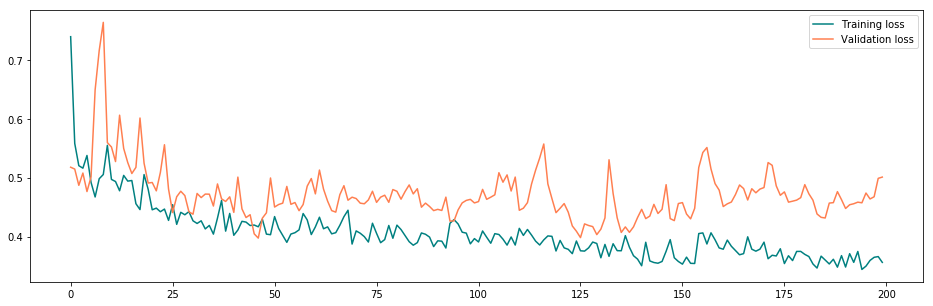

In [510]:
#Plot performance over epochs
from matplotlib import pyplot as plt

#Create ticks on x axis from 0 through the number of epochs
x = np.arange(0,epochs)

lines = [loss_results,val_loss_results]
colors  = ['teal','coral']
labels  = ['Training loss','Validation loss']

# Adjust default plot size
plt.figure(figsize=(16,5))

for i,c,l in zip(lines,colors,labels):  
    plt.plot(x,i,c,label='l')
    plt.legend(labels)
               
plt.show()

Print results of all runs to help guide future model experimentation

In [511]:
#Save model performance to dataframe
model_perf_df.loc[len(model_perf_df)] = [format(best_loss, '.4f'), best_epoch, hidden_drop_out, kern_regularizer, act_regularizer, hidden_dense_size, hidden_activation, final_activation, batch_size, vars_used_str] 

#Print dataframe with model performance
print(model_perf_df.to_string(index=False))

BestLoss Epoch  Dropout        KerReg        ActReg HidDense HidAct   FinAct Batch                     Vars
 0.3939    44     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9
 0.3975    47     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9


## Test model against test set
Test model against test set by rounding the predictions which are decimals to True / False values. Then, create an array which tracks whether or not the model predicted correctly predicted whether or not a location was a vineyard or not. 

In [512]:
#get predictions with probability values
y_hat = model.predict([elevation[-test_n:], map_coords[-test_n:],wind_dir[-test_n:],wind_spd[-test_n:],precip[-test_n:], temp[-test_n:], min_temp[-test_n:], max_temp[-test_n:], clouds[-test_n:], ghi[-test_n:], rh[-test_n:]], verbose=1)

#Round probabilities to 1s or 0s to test the accuracy of our train 
accuracy = np.array([])
i = 0
while i < len(y_hat):
    rounded_predict = round(y_hat[i][0])
    
    #Was the prediction correct?
    correct = rounded_predict == is_vineyard[-test_n:][i]
    accuracy = np.append(accuracy, correct)
    
    i = i +1

40/40 [==============================] - 4s 102ms/step


Percent of locations classified correctly in our test set...

In [513]:
print('Correct responses = ' + str(np.mean(accuracy)*100) + '%')

Correct responses = 95.0%
